<a href="https://colab.research.google.com/github/nmedvedeva312/ML-Course-HW/blob/main/HW_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
"""Реализовать минимум 5 регрессоров, сравнить метрики между собой, выбрать лучший для Вашего датасета.
Для работы используется датасет Wine Quality Data Set (Red & White Wine)."""

'Реализовать минимум 5 регрессоров, сравнить метрики между собой, выбрать лучший для Вашего датасета.\nДля работы используется датасет Wine Quality Data Set (Red & White Wine).'

In [6]:
# ЭТАП 1: Импорт библиотек

In [7]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [8]:
# ЭТАП 2: Загрузка и первичный анализ данных

In [9]:
# Загрузка датасета California Housing
california = fetch_california_housing()

# Преобразуем в DataFrame
df = pd.DataFrame(california.data, columns=california.feature_names)
df['Target'] = california.target

In [10]:
# Получаем информацию о датасете и проверяем типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   Target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [11]:
# Получаем базовую статистику
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [12]:
# Проверяем на пропуски
df.isnull().sum()

,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
Target,0


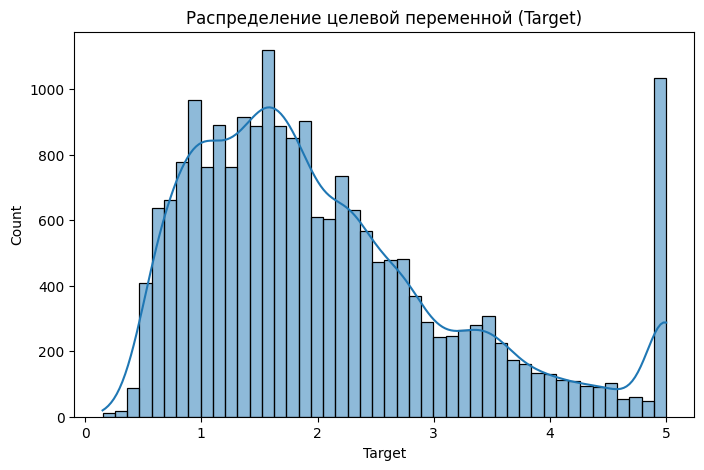

In [13]:
# Визуализируем распределение целевой переменной
plt.figure(figsize=(8, 5))
sns.histplot(df['Target'], kde=True)
plt.title('Распределение целевой переменной (Target)')
plt.xlabel('Target')
plt.show()

In [14]:
# ЭТАП 3: Очистка данных — удаление выбросов (по IQR)

In [15]:
# Используем межквантильный размах для фильтрации выбросов
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Удаляем строки, содержащие выбросы по любому признаку
df_clean = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

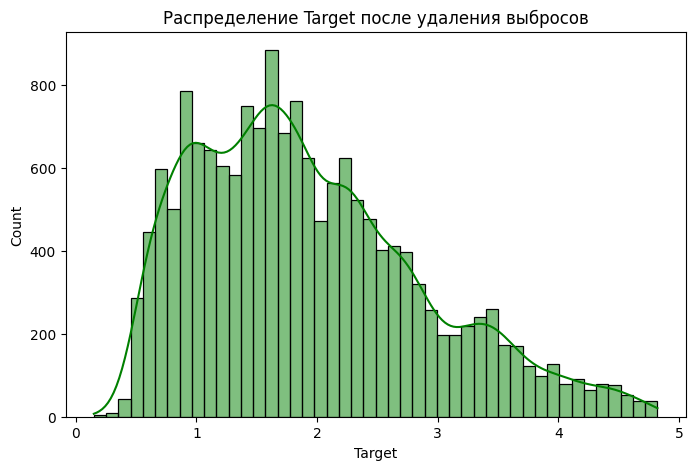

In [16]:
# Визуализируем распределение целевой переменной после очистки данных
plt.figure(figsize=(8, 5))
sns.histplot(df_clean['Target'], kde=True, color='green')
plt.title('Распределение Target после удаления выбросов')
plt.xlabel('Target')
plt.show()

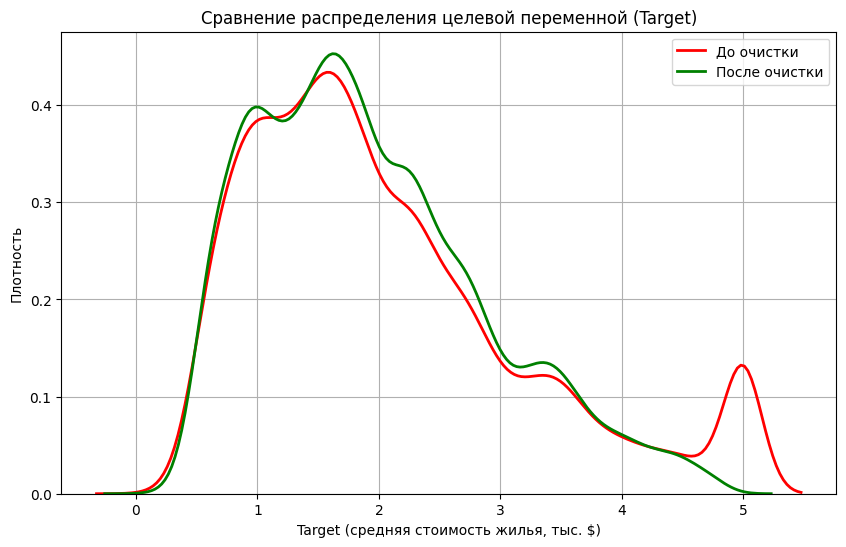

In [17]:
# Сравнительная визуализация распределения Target ДО и ПОСЛЕ удаления выбросов
plt.figure(figsize=(10, 6))

sns.kdeplot(df['Target'], label='До очистки', color='red', linewidth=2)
sns.kdeplot(df_clean['Target'], label='После очистки', color='green', linewidth=2)

plt.title('Сравнение распределения целевой переменной (Target)')
plt.xlabel('Target (средняя стоимость жилья, тыс. $)')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# ЭТАП 4: Разделение на признаки и целевую переменную + масштабирование

In [19]:
# Разделяем X и y
X = df_clean.drop(columns=['Target'])
y = df_clean['Target']

# Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабируем данные (StandardScaler нужен для большинства моделей)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# ЭТАП 5: Обучение 7 регрессионных моделей и оценка качества

In [21]:
# Инициализация моделей
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42)
}

results = []

# Обучение каждой модели и сбор метрик
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results.append({
        "Model": name,
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R²": r2_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results)


Результаты этапа 5 — метрики моделей:
               Model       MAE       MSE      RMSE        R²
0  Linear Regression  0.423553  0.316522  0.562603  0.637896
1              Ridge  0.423536  0.316504  0.562587  0.637917
2              Lasso  0.757672  0.875137  0.935487 -0.001162
3         ElasticNet  0.724049  0.802865  0.896027  0.081518
4      Random Forest  0.290993  0.178472  0.422460  0.795827
5  Gradient Boosting  0.322695  0.204944  0.452707  0.765543
6           AdaBoost  0.626973  0.535721  0.731930  0.387132


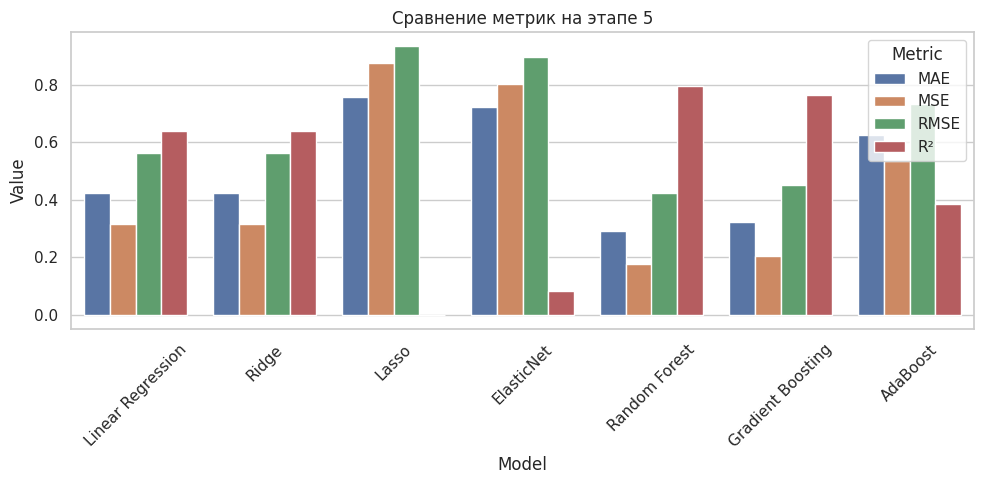

In [22]:
# Таблица результатов этапа 5
print("\nРезультаты этапа 5 — метрики моделей:")
print(results_df)

# Визуализация барплотом
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.barplot(
    data=results_df.melt(
        id_vars="Model",
        value_vars=["MAE", "MSE", "RMSE", "R²"],
        var_name="Metric",
        value_name="Value"
    ),
    x="Model",
    y="Value",
    hue="Metric"
)
plt.xticks(rotation=45)
plt.title("Сравнение метрик на этапе 5")
plt.tight_layout()
plt.show()

In [23]:
"""Выводы
- Random Forest показал лучшие результаты (MAE ≈ 0.29, RMSE ≈ 0.42, R² ≈ 0.80).
- Gradient Boosting немного уступает (R² ≈ 0.77), но остаётся сильным кандидатом.
- Линейные модели (Linear, Ridge) показали средний уровень (R² ≈ 0.64).
- Lasso и ElasticNet при текущих настройках недообучаются (R² ≤ 0.08).
- AdaBoost дал посредственные результаты (R² ≈ 0.39).

Дальнейшие шаги
1. Детальная настройка **Random Forest** и **Gradient Boosting**.
2. Попробовать Boosting-модели XGBoost, LightGBM
3. Убрать Lasso/ElasticNet и AdaBoost или подбирать новые гиперпараметры."""

'Выводы\n- Random Forest показал лучшие результаты (MAE ≈ 0.29, RMSE ≈ 0.42, R² ≈ 0.80).\n- Gradient Boosting немного уступает (R² ≈ 0.77), но остаётся сильным кандидатом.\n- Линейные модели (Linear, Ridge) показали средний уровень (R² ≈ 0.64).\n- Lasso и ElasticNet при текущих настройках недообучаются (R² ≤ 0.08).\n- AdaBoost дал посредственные результаты (R² ≈ 0.39).\n\nДальнейшие шаги\n1. Детальная настройка **Random Forest** и **Gradient Boosting**.\n2. Попробовать Boosting-модели XGBoost, LightGBM\n3. Убрать Lasso/ElasticNet и AdaBoost или подбирать новые гиперпараметры.'

In [24]:
# ЭТАП 6: Глубокая настройка Random Forest, Gradient Boosting, XGBoost, LightGBM

In [31]:
# Импорт модулей
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Инициализация списка для хранения результатов
results = []

# Функция для оценки модели
def evaluate_model(name, model, tuned=False, params=None):
    model.fit(X_train, y_train)     # Обучение модели
    y_pred = model.predict(X_test)  # Предсказания на тестовой выборке
    results.append({                # Сохраняем метрики в список
        "Model": f"{name} ({'после' if tuned else 'до'})",
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R²": r2_score(y_test, y_pred),
        "Params": params if tuned else model.get_params()
    })

# Словарь моделей с параметрами для RandomizedSearchCV
model_configs = {
    "Random Forest": (
        RandomForestRegressor(random_state=42),
        {
            'n_estimators': [100, 200],         # Количество деревьев в лесу
            'max_depth': [None, 10],            # Максимальная глубина каждого дерева
            'min_samples_split': [2, 5],        # Минимальное количество образцов для разделения узла
            'min_samples_leaf': [1, 2],         # Минимальное количество образцов в листовом узле
            'max_features': ['auto', 'sqrt']    # Количество признаков для рассмотрения при разбиении, 'auto' (или 'sqrt') — корень из общего числа признаков
        }
    ),
    "Gradient Boosting": (
        GradientBoostingRegressor(random_state=42),
        {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5],
            'subsample': [0.8, 1.0],
            'min_samples_split': [2, 5]
        }
    ),
    "XGBoost": (
        XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0),
        {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    ),
    "LightGBM": (
        LGBMRegressor(random_state=42),
        {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5],
            'num_leaves': [31, 50],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    )
}

# Цикл по моделям
for name, (model, param_dist) in model_configs.items():
    print(f"Обучение модели: {name} (до тюнинга)")
    # До тюнинга
    evaluate_model(name, model, tuned=False) # Сохраняем результаты до подбора гиперпараметров

    # После тюнинга
    print(f"Тюнинг модели: {name}")
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=3,     # Кол-во случайных комбинаций (можно увеличить)
        cv=3,         # Кросс-валидация
        scoring='r2', # Целевая метрика для оптимизации
        random_state=42,
        n_jobs=1,     # Число потоков
        verbose=0
    )
    search.fit(X_train, y_train)  # Поиск лучших параметров
    best_model = search.best_estimator_
    evaluate_model(name, best_model, tuned=True, params=search.best_params_)


Обучение модели: Random Forest (до тюнинга)
Тюнинг модели: Random Forest
Обучение модели: Gradient Boosting (до тюнинга)
Тюнинг модели: Gradient Boosting
Обучение модели: XGBoost (до тюнинга)
Тюнинг модели: XGBoost
Обучение модели: LightGBM (до тюнинга)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 13049, number of used features: 8
[LightGBM] [Info] Start training from score 1.933812
Тюнинг модели: LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 8699, number of used features: 8
[LightGBM] [Info] Start training from score 1.930358
[LightGBM] [Warning] No further splits wi

In [32]:
# Преобразуем результаты в DataFrame
results_df = pd.DataFrame(results)

# Выводим результаты
print(results_df)

                       Model       MAE       MSE      RMSE        R²  \
0         Random Forest (до)  0.290807  0.178354  0.422320  0.795961   
1      Random Forest (после)  0.298132  0.177806  0.421670  0.796589   
2     Gradient Boosting (до)  0.322712  0.204946  0.452710  0.765540   
3  Gradient Boosting (после)  0.286909  0.169371  0.411547  0.806239   
4               XGBoost (до)  0.268934  0.154048  0.392489  0.823768   
5            XGBoost (после)  0.269562  0.148337  0.385145  0.830302   
6              LightGBM (до)  0.272362  0.152996  0.391147  0.824971   
7           LightGBM (после)  0.287723  0.168457  0.410435  0.807284   

                                              Params  
0  {'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...  
1  {'n_estimators': 200, 'min_samples_split': 5, ...  
2  {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...  
3  {'subsample': 1.0, 'n_estimators': 100, 'min_s...  
4  {'objective': 'reg:squarederror', 'base_score'...  
5  {'subsample': 1.0,

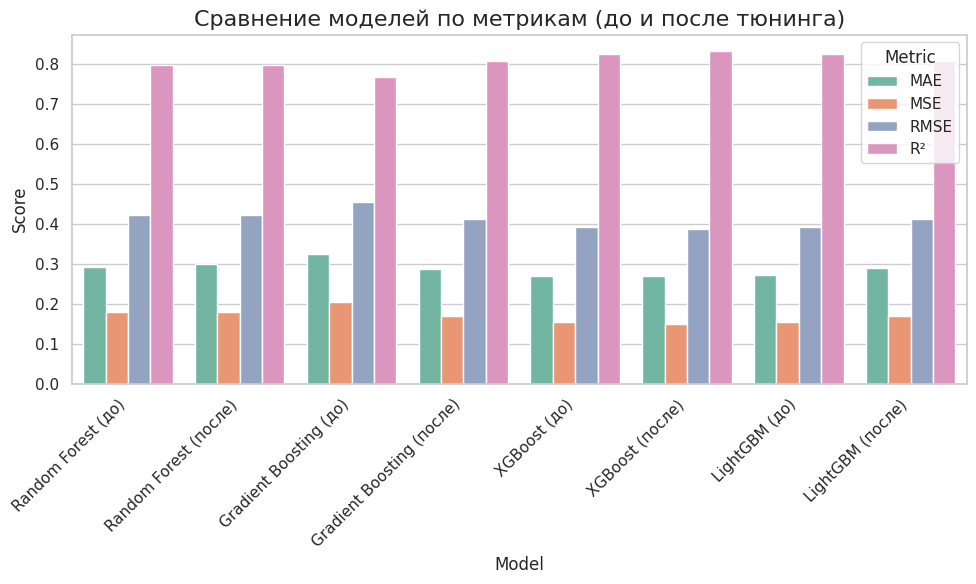

In [33]:
# Преобразуем таблицу в формат, удобный для визуализации
results_df_melted = results_df.melt(id_vars=["Model", "Params"], value_vars=["MAE", "MSE", "RMSE", "R²"],
                                    var_name="Metric", value_name="Score")

# Создание графика
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Score", hue="Metric", data=results_df_melted, palette="Set2")

# Добавление заголовка и меток
plt.title("Сравнение моделей по метрикам (до и после тюнинга)", fontsize=16)
plt.ylabel("Score", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Показать график
plt.show()

In [34]:
"""Выводы:
Лучшие результаты показала модель XGBoost, с незначительным улучшением после тюнинга.
Gradient Boosting показала наибольшее улучшение после тюнинга, улучшив R².
Random Forest и LightGBM показали стабильность, но улучшения были минимальными."""

'Выводы:\nЛучшие результаты показала модель XGBoost, с незначительным улучшением после тюнинга.\nGradient Boosting показала наибольшее улучшение после тюнинга, улучшив R².\nRandom Forest и LightGBM показали стабильность, но улучшения были минимальными.'

In [35]:
# Анализ важности признаков для каждой модели

In [37]:
# Список для хранения результатов важности признаков
imp_results = []

# Получаем важность признаков для каждой модели
for name, (model, param_dist) in model_configs.items():
    # Проверяем, если модель имеет атрибут feature_importances_
    if hasattr(model, 'feature_importances_'):
        imp = pd.DataFrame({
            'Feature': X.columns,
            'Importance': model.feature_importances_,
            'Model': name
        })
        imp_results.append(imp)

# Объединяем данные о важности признаков в один DataFrame
imp_df = pd.concat(imp_results)

# Сортируем по важности признаков
imp_df = imp_df.sort_values(by=['Model', 'Importance'], ascending=[True, False])

# Выводим сводную таблицу
print(imp_df)

      Feature  Importance              Model
0      MedInc    0.494625  Gradient Boosting
7   Longitude    0.164830  Gradient Boosting
6    Latitude    0.147106  Gradient Boosting
5    AveOccup    0.124586  Gradient Boosting
2    AveRooms    0.032922  Gradient Boosting
1    HouseAge    0.027808  Gradient Boosting
4  Population    0.004421  Gradient Boosting
3   AveBedrms    0.003702  Gradient Boosting
7   Longitude  764.000000           LightGBM
6    Latitude  716.000000           LightGBM
5    AveOccup  356.000000           LightGBM
0      MedInc  345.000000           LightGBM
2    AveRooms  246.000000           LightGBM
1    HouseAge  232.000000           LightGBM
4  Population  202.000000           LightGBM
3   AveBedrms  139.000000           LightGBM
0      MedInc    0.430837      Random Forest
5    AveOccup    0.141289      Random Forest
7   Longitude    0.127026      Random Forest
6    Latitude    0.116236      Random Forest
2    AveRooms    0.063322      Random Forest
1    House

In [38]:
"""Вывод:
MedInc (доход населения) — самый важный признак для всех моделей, что подтверждает его значимость для определения цен на жилье.
Longitude и Latitude — важны для всех моделей, указывая на влияние географического положения.
AveOccup (плотность населения) и AveRooms (среднее количество комнат) — умеренно важные признаки, особенно для Gradient Boosting и XGBoost.
HouseAge (возраст дома) и Population (плотность населения в районе) — имеют меньшую важность, но всё же оказывают влияние.
AveBedrms (среднее количество спален) — наименее важный признак для всех моделей.
Основной вывод: Доход населения и географическое положение имеют наибольшее значение для предсказания цен на жилье."""

'Вывод:\nMedInc (доход населения) — самый важный признак для всех моделей, что подтверждает его значимость для определения цен на жилье.\nLongitude и Latitude — важны для всех моделей, указывая на влияние географического положения.\nAveOccup (плотность населения) и AveRooms (среднее количество комнат) — умеренно важные признаки, особенно для Gradient Boosting и XGBoost.\nHouseAge (возраст дома) и Population (плотность населения в районе) — имеют меньшую важность, но всё же оказывают влияние.\nAveBedrms (среднее количество спален) — наименее важный признак для всех моделей.\nОсновной вывод: Доход населения и географическое положение имеют наибольшее значение для предсказания цен на жилье.'